A simple approach for nuclei segmentation using R; keras, tidyverse and EBImage. 

Some settings are just for illustration i.e. height, width, number of epochs or the number levels in the U-Net, etc. 

Loading required libraries:

In [97]:
library(keras)
library(tidyverse)
library(EBImage)
options(EBImage.display = "raster") 

Defining some parameters:

In [98]:
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'
HEIGHT = 256/2
WIDTH = 256/2
CHANNELS = 3
SHAPE = c(WIDTH, HEIGHT, CHANNELS)
BATCH_SIZE = 16
EPOCHS = 10

## Prepare training images
   	
Prepare for reading training data:

In [99]:
train_data <- read_csv("../input/stage1_train_labels.csv") %>%
    group_by(ImageId) %>%
    summarize(EncodedPixels = list(EncodedPixels)) %>%
    mutate(ImageFile = file.path(TRAIN_PATH, ImageId, "images", paste0(ImageId, ".png")),
           MaskPath = file.path(TRAIN_PATH, ImageId, "masks"),
           MaskFiles = map(MaskPath, list.files, pattern="*.png", full.names = TRUE),
           ImageShape =  map(ImageFile, .f = function(file) dim(readImage(file))[1:2]))
train_data %>%
    glimpse()

Parsed with column specification:
cols(
  ImageId = col_character(),
  EncodedPixels = col_character()
)


Observations: 670
Variables: 6
$ ImageId       <chr> "00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04...
$ EncodedPixels <list> [<"6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440 9 ...
$ ImageFile     <chr> "../input/stage1_train//00071198d059ba7f5914a526d124d...
$ MaskPath      <chr> "../input/stage1_train//00071198d059ba7f5914a526d124d...
$ MaskFiles     <list> [<"../input/stage1_train//00071198d059ba7f5914a526d1...
$ ImageShape    <list> [<256, 256>, <256, 256>, <320, 256>, <320, 256>, <32...


I use the encoded the masks in stead of reading them. Note that  for
decoding the original image dimensions are required.

Here is a function to decode the run length encoded masks into images, combining all masks in one image:

In [100]:
rle2masks <- function(encodings, shape) {

    ## Convert rle encoded mask to image
    rle2mask <- function(encoding, shape){

        splitted <- as.integer(str_split(encoding, pattern = "\\s+", simplify=TRUE))
        positions <- splitted[seq(1, length(splitted), 2)]
        lengths <- splitted[seq(2, length(splitted), 2)] - 1

        ## decode
        mask_indices <- unlist(map2(positions, lengths, function(pos, len) seq.int(pos, pos+len)))

        if(max(mask_indices) > prod(shape)){
            print(max(mask_indices))
            print(prod(shape))
            stop("Encoding doesn't match with given shape!")
        }

        ## shape as 2D image
        mask <- numeric(prod(shape))
        mask[mask_indices] <- 1
        mask <- matrix(mask, nrow=shape[1], ncol=shape[2], byrow=TRUE)
        mask
    }

    masks <- matrix(0, nrow=shape[1], ncol=shape[2])
    for(i in 1:length(encodings))
        masks <- masks + rle2mask(encodings[i], shape)

    ## Check if all masks are non-overlapping
    if(!all(masks <= 1))
        message("Overlapping masks")
    masks
}

A little preprocessing is performed on the original images,
i.e. resizing, inversion of brightfield images and normalization:


In [101]:
## Invert Brightfield images: background black/foreground white
invert <- function(x) {
    if(mean(x) > .5)
        x <- 1 - x
    x
}

## Preprocess original images
preprocess_image <- function(file, shape){
    image <- readImage(file, type="png")[,,1:3]         ## drop fourth channel
    image <- resize(image, w = shape[1], h = shape[2])  ## make all images of dimensions
    image <- normalize(image)                           ## standardize between [0, 1]
    image <- invert(image)                              ## invert brightfield
    imageData(image)                                    ## return as array
}

## Preprocess masks
preprocess_masks <- function(encoding, old_shape, new_shape){
    masks <- Image(rle2masks(encoding, old_shape))
    masks <- resize(masks, w = new_shape[1], h = new_shape[2])
    masks <- imageData(masks)
    dim(masks) <- c(dim(masks), 1) ##masks have no color channels
    masks
}


The last two preprocessing functions combine all preprocessing steps
(additional steps are easily added; i.e, global contrast
normalization).

Extract a random train image and display:

In [102]:
rand_images <- sample_n(train_data, 1) %>%
    mutate(Y = map2(EncodedPixels, ImageShape, preprocess_masks, new_shape = SHAPE),
           X = map(ImageFile, preprocess_image, shape = SHAPE)) %>%
    select(X,Y)
str(rand_images)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1 obs. of  2 variables:
 $ X:List of 1
  ..$ : num [1:128, 1:128, 1:3] 0.257 0.19 0.108 0.108 0.109 ...
 $ Y:List of 1
  ..$ : num [1:128, 1:128, 1] 0 0 0 0 0 0 0 0 0 0 ...


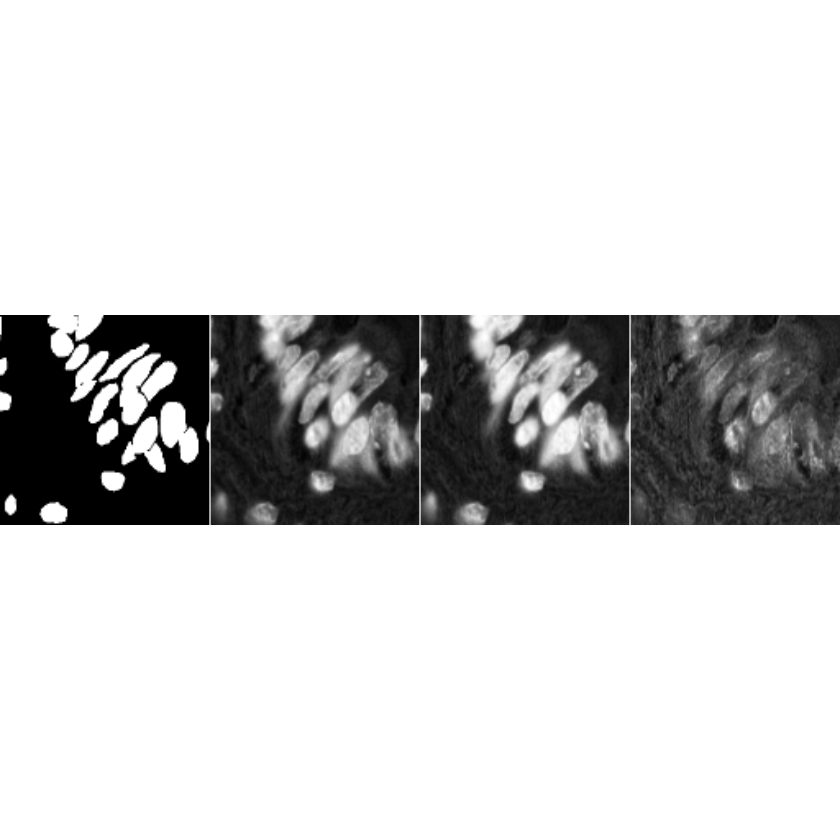

In [103]:
display(combine(rand_images$Y[[1]], rand_images$X[[1]]), all = TRUE, nx = 4)

## Define U-Net
	
The following two functions are used to construct the U-net; a function two construct a general U-Net layer and a function to construct the U-Net itself:


In [104]:
## unet 2x2 2DConv layer
unet_layer <- function(object, filters, kernel_size = c(3, 3),
                       padding = "same", kernel_initializer = "he_normal",
                       dropout = 0.1, activation="relu"){

    object %>%
        layer_conv_2d(filters = filters, kernel_size = kernel_size, padding = padding) %>%
        ##layer_batch_normalization() %>%
        layer_activation(activation) %>%
        layer_spatial_dropout_2d(rate = dropout) %>%
        layer_conv_2d(filters = filters, kernel_size = kernel_size, padding = padding) %>%
        ##layer_batch_normalization() %>%
        layer_activation(activation)
}
unet <- function(shape, nlevels = 4, nfilters = 16, dropouts = c(0.1, 0.1, 0.2, 0.2, 0.3)){

    message("Constructing U-Net with ", nlevels, " levels initial number of filters is: ", nfilters)
    
    filter_sizes <- nfilters*2^seq.int(0, nlevels)

    ## Loop over contracting layers
    clayers <- clayers_pooled <- list()

    ## inputs
    clayers_pooled[[1]] <- layer_input(shape = shape)

    for(i in 2:(nlevels+1)) {
        clayers[[i]] <- unet_layer(clayers_pooled[[i - 1]],
                                   filters = filter_sizes[i - 1],
                                   dropout = dropouts[i-1])

        clayers_pooled[[i]] <- layer_max_pooling_2d(clayers[[i]],
                                                    pool_size = c(2, 2),
                                                    strides = c(2, 2))
    }

    ## Loop over expanding layers
    elayers <- list()

    ## center
    elayers[[nlevels + 1]] <- unet_layer(clayers_pooled[[nlevels + 1]],
                                         filters = filter_sizes[nlevels + 1],
                                         dropout = dropouts[nlevels + 1])

    for(i in nlevels:1) {
        elayers[[i]] <- layer_conv_2d_transpose(elayers[[i+1]],
                                                filters = filter_sizes[i],
                                                kernel_size = c(2, 2),
                                                strides = c(2, 2),
                                                padding = "same")

        elayers[[i]] <- layer_concatenate(list(elayers[[i]], clayers[[i + 1]]), axis = 3)
        elayers[[i]] <- unet_layer(elayers[[i]], filters = filter_sizes[i], dropout = dropouts[i])

    }

    ## Output layer
    outputs <- layer_conv_2d(elayers[[1]], filters = 1, kernel_size = c(1, 1), activation = "sigmoid")

    return(keras_model(inputs = clayers_pooled[[1]], outputs = outputs))
}


Define a U-Net model with 3 contracting- and expanding-levels and 16
filters in the first convolution layer.


In [105]:
model <- unet(shape = SHAPE, nlevels = 3, nfilters = 16, dropouts = c(0.1, 0.1, 0.2, 0.3))
summary(model)

Constructing U-Net with 3 levels initial number of filters is: 16


________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_3 (InputLayer)      (None, 128, 128,  0                                   
________________________________________________________________________________
conv2d_27 (Conv2D)        (None, 128, 128,  448      input_3[0][0]              
________________________________________________________________________________
activation_25 (Activation (None, 128, 128,  0        conv2d_27[0][0]            
________________________________________________________________________________
spatial_dropout2d_13 (Spa (None, 128, 128,  0        activation_25[0][0]        
________________________________________________________________________________
conv2d_28 (Conv2D)        (None, 128, 128,  2320     spatial_dropout2d_13[0][0] 
________________________________________________________________________________
activation_26 (Activation (N

Defining dice coefficient and its negative as loss function using
keras-backend functions (`k_*`).


In [106]:
dice_coef <- function(y_true, y_pred, smooth = 1.0) {
    y_true_f <- k_flatten(y_true)
    y_pred_f <- k_flatten(y_pred)
    intersection <- k_sum(y_true_f * y_pred_f)
    (2 * intersection + smooth) / (k_sum(y_true_f) + k_sum(y_pred_f) + smooth)
}
attr(dice_coef, "py_function_name") <- "dice_coef"

dice_coef_loss <- function(y_true, y_pred) -dice_coef(y_true, y_pred)
attr(dice_coef_loss, "py_function_name") <- "dice_coef_loss"

The `attr` specification is needed if you want to store the fitted
model for later use!

Add the metric and loss to the model:


In [107]:
model <- model %>%
    compile(
        optimizer = 'adam',
        loss = dice_coef_loss,
        metrics = c(dice_coef)
    )

## Training the U-Net
   	
Extract all data and convert to tensors:


In [108]:
input <- sample_n(train_data, nrow(train_data)) %>%
    mutate(Y = map2(EncodedPixels, ImageShape, preprocess_masks, new_shape = SHAPE),
           X = map(ImageFile, preprocess_image, shape = SHAPE)) %>%
    select(X,Y)

input %>%
    glimpse()

list2tensor <- function(xList) {
    xTensor <- simplify2array(xList)
    aperm(xTensor, c(4, 1, 2, 3))    
}

X <- list2tensor(input$X)
Y <- list2tensor(input$Y)

dim(Y)
dim(X)

Observations: 670
Variables: 2
$ X <list> [<0.521149242, 0.683160415, 0.738228252, 0.770151636, 0.78371907...
$ Y <list> [<0.000, 1.000, 1.000, 1.000, 1.000, 0.875, 0.000, 1.000, 1.000,...


[1] 670 128 128   1

[1] 670 128 128   3

`input` is a `data.frame`, actually a `tibble`, with so-called
list-columns `X` and `Y` each element containing an image. For use
with keras/tensorflow these need to be transformed to tensors (samples
x width x height x channels).

Fit the model:

In [109]:
history <- model %>%
    fit(X, Y,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_split = 0.2,
       verbose = 1)

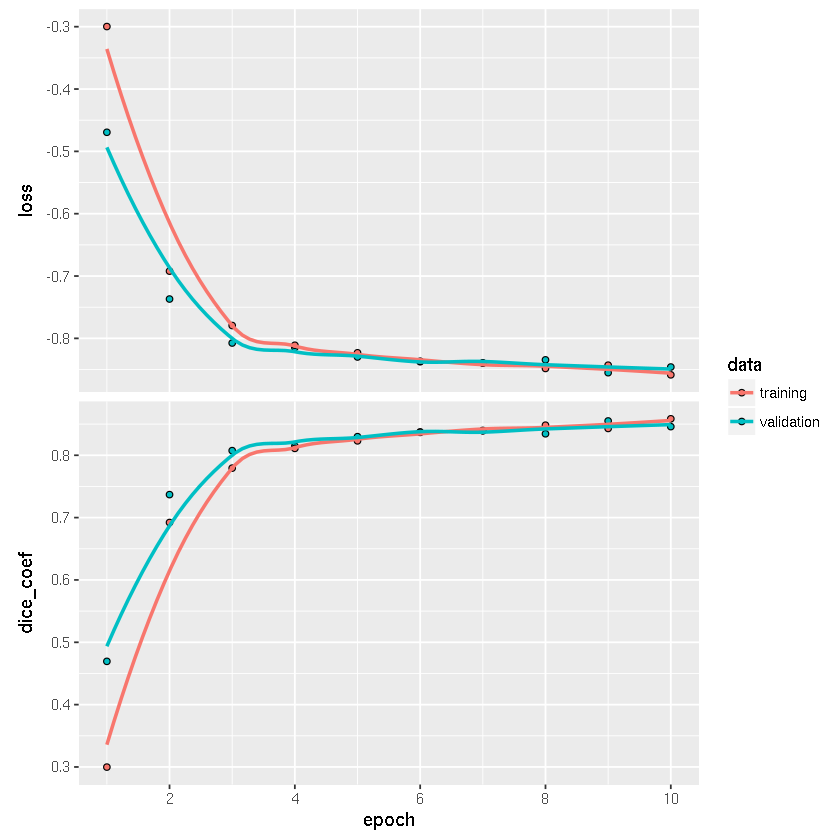

In [110]:
plot(history)

Optionally save the model:

In [111]:
## save_model_hdf5(model, filepath="unet_model.hdf5")

## Evaluate the fitted model
	
Predict and evaluate on training images: 


In [112]:
Y_hat <- predict(model, x = X)

Display an original image with given masks:

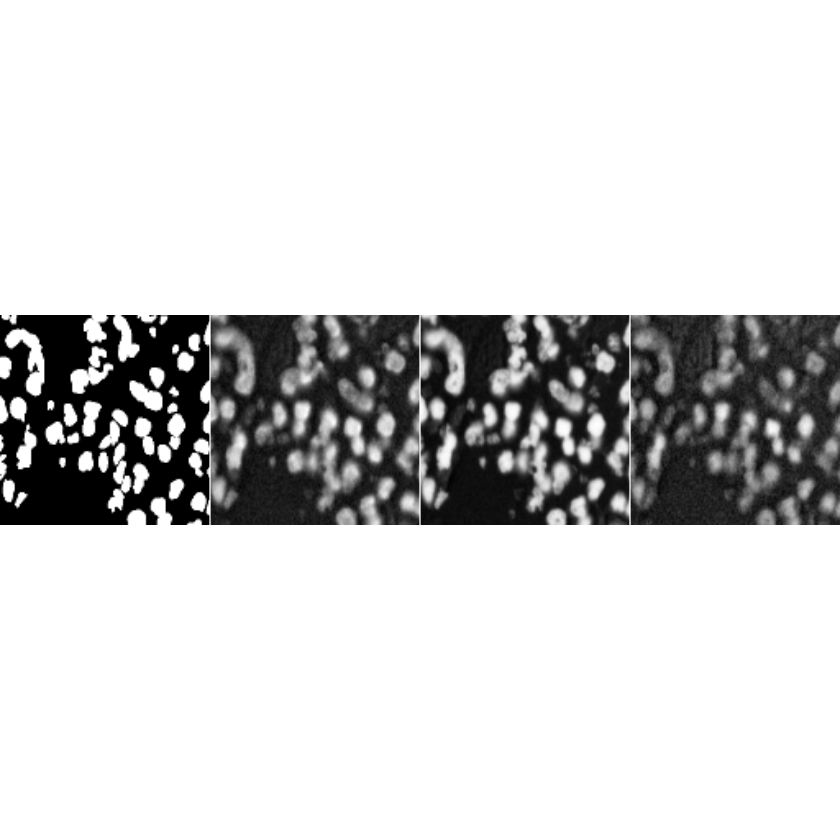

In [113]:
display(combine(Y[1,,,], X[1,,,]), all = TRUE, nx = 4)

Display original with predicted masks:

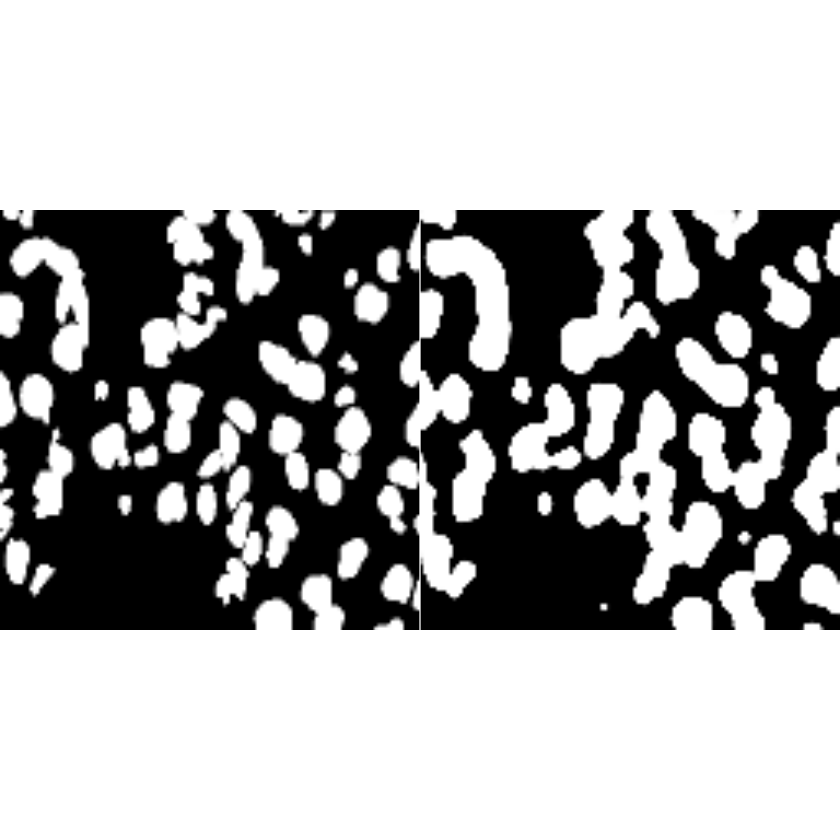

In [114]:
display(combine(Y[1,,,], Y_hat[1,,,]), all = TRUE)

## Intersection over Union and Mean Precision
	
These functions require labeled images as input!

In [115]:
iou <- function(y_true, y_pred){
    y_true <- as.vector(y_true)
    y_pred <- as.vector(y_pred)
    nbins <- max(y_true, y_pred)
    intersections <- tabulate(sqrt(y_true*y_pred), nbins = nbins)
    true_sizes <- tabulate(y_true, nbins = nbins)
    pred_sizes <- tabulate(y_pred, nbins = nbins)
    unions <- true_sizes + pred_sizes - intersections   
    return(intersections/unions)
}

mean_precision <- function(y_true, y_pred, thresholds = seq(0.5, 0.95, 0.05)) {
    ious <- iou(y_true, y_pred)
    ground_truth <- logical(max(y_true, y_pred))
    ground_truth[1:max(y_true)] <- TRUE
    precision <- 0
    for(t in thresholds) {
        tp <- sum(ious[ground_truth] > t)
        fp <- sum(ious[!ground_truth] > t)
        fn <- sum(ious[ground_truth] <= t)
        precision <- precision + tp/(tp+fp+fn)
    }
    precision/length(thresholds)
}


Estimate mean precision on the training data:

[1] 0.55

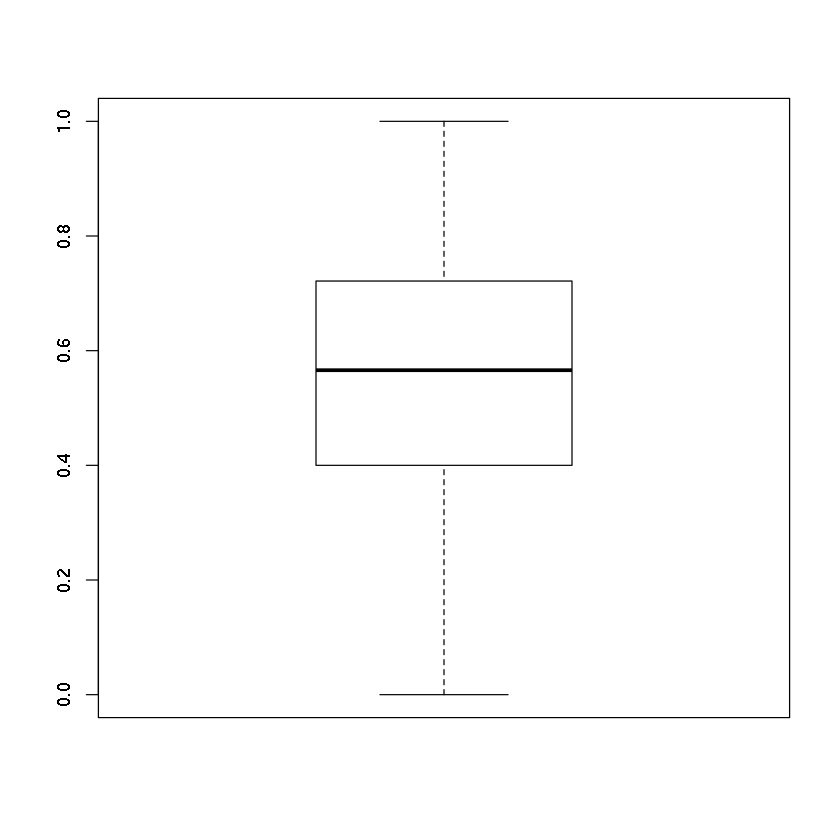

In [116]:
Z <- map(array_branch(Y, 1), bwlabel)
Z_hat <- map(array_branch(Y_hat, 1), .f = function(z) bwlabel(z > .5))
mp <- map2_dbl(Z, Z_hat, mean_precision)
round(mean(mp), 2)
boxplot(mp)

## Perform predictions on the test images
   	
Prepare for reading stage I test data:


In [117]:
test_data <- tibble(ImageId = dir(TEST_PATH)) %>%
    mutate(ImageFile = file.path(TEST_PATH, ImageId, "images", paste0(ImageId, ".png")),
           ImageShape =  map(ImageFile, .f = function(file) dim(readImage(file))[1:2]))
test_data %>%
    glimpse()

Observations: 65
Variables: 3
$ ImageId    <chr> "0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c...
$ ImageFile  <chr> "../input/stage1_test//0114f484a16c152baa2d82fdd43740880...
$ ImageShape <list> [<256, 256>, <253, 519>, <256, 256>, <256, 256>, <256, ...


Extract the test images and predict:	

Observations: 65
Variables: 4
$ ImageId    <chr> "0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c...
$ ImageFile  <chr> "../input/stage1_test//0114f484a16c152baa2d82fdd43740880...
$ ImageShape <list> [<256, 256>, <253, 519>, <256, 256>, <256, 256>, <256, ...
$ X          <list> [<0.017241379, 0.024137931, 0.027586207, 0.024137931, 0...


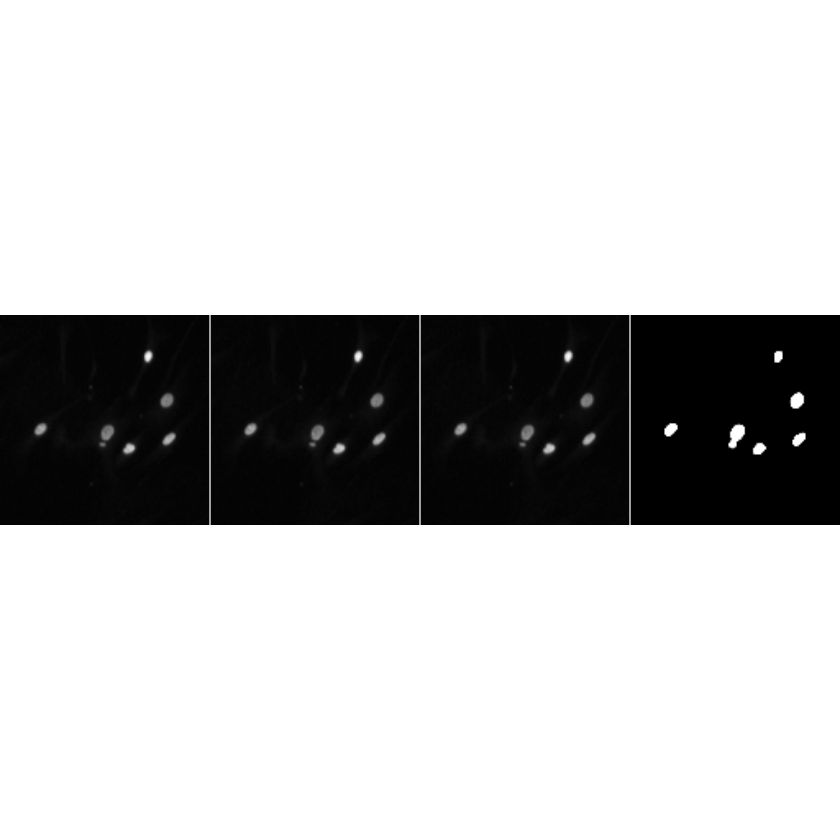

In [118]:
test_data <- test_data %>%
    mutate(X = map(ImageFile, preprocess_image, shape = SHAPE))

test_data %>%
    glimpse()

X <- list2tensor(test_data$X)

Y_hat <- predict(model, x = X)

display(combine(X[1,,,], Y_hat[1,,,]), all = TRUE, nx = 4)

Perform encoding:

In [119]:
image2rle <- function(image){

    labels <- 1:max(image) ## assuming background  == 0

    x <- as.vector(t(EBImage::imageData(image)))

    encoding <- rle(x)

    ## Adding start positions
    encoding$positions <- 1 + c(0, cumsum(encoding$lengths[-length(encoding$lengths)]))

    mask2rle <- function(label, enc) {
        indices <- enc$values == label
        paste(enc$positions[indices], enc$lengths[indices], collapse=" ")
    }

    map(labels, mask2rle, encoding) %>%
        setNames(labels)
}

postprocess_image <- function(image, shape){
    image <- resize(image[,,1], w = shape[1], h = shape[2])
    image <- bwlabel(image > .5)
    image2rle(image)
}


The post processing steps include; resizing to original image
dimension, label segmented image and perform run length encoding.


Observations: 3
Variables: 2
$ X     <list> [<0.5487745098, 0.4035539216, 0.2516544118, 0.1555759804, 0....
$ Y_hat <list> [<1.000000, 1.000000, 0.000000, 0.000000, 0.000000, 0.000000...
 num [1:3, 1:128, 1:128, 1:3] 0.549 0.099 0.023 0.404 0.205 ...
 num [1:3, 1:128, 1:128, 1] 1 0 0 1 0.266 ...


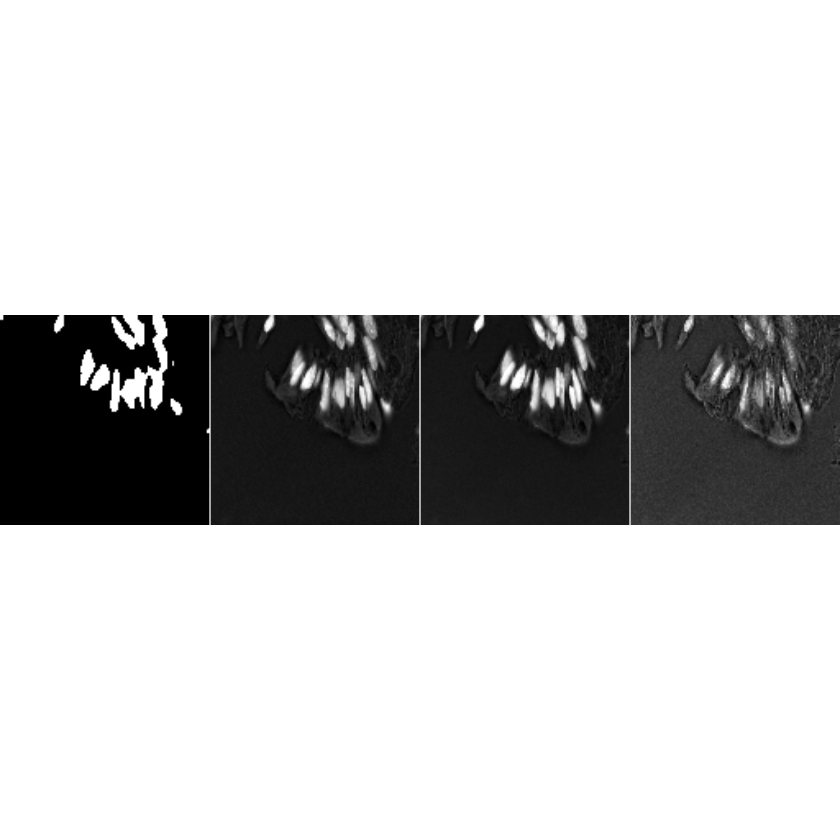

In [120]:
submission <- test_data %>%
    add_column(Masks = array_branch(Y_hat, 1)) %>%
    mutate(EncodedPixels = map2(Masks, ImageShape, postprocess_image))

## check encoding
rsamples <- sample_n(submission, 3) %>%
    mutate(Y_hat = map2(EncodedPixels, ImageShape, preprocess_masks, new_shape = SHAPE),
           X = map(ImageFile, preprocess_image, shape = SHAPE)) %>%
    select(X,Y_hat)

rsamples %>%
    glimpse()

X <- list2tensor(rsamples$X)
Y_hat <- list2tensor(rsamples$Y_hat)
str(X)
str(Y_hat)

display(combine(Y_hat[1,,,], X[1,,,]), all = TRUE, nx = 4)

Submit:

In [121]:
submission <- submission %>%
    unnest(EncodedPixels) %>%
    mutate(EncodedPixels = as.character(EncodedPixels)) %>%
    select(ImageId, EncodedPixels)

submission %>%
    glimpse()
write_csv(submission, "submission.csv")


Observations: 1,759
Variables: 2
$ ImageId       <chr> "0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac4...
$ EncodedPixels <chr> "45103 11 45359 12 45613 14 45869 14 46125 14 46381 1...
